
Загружаем первый ряд: daily-total-female-births-in-cal.csv
Пожалуйста, загрузите файл через интерфейс Colab.


Saving daily-total-female-births-in-cal.csv to daily-total-female-births-in-cal (1).csv
Проверяем пропуски в данных:
Value    0
dtype: int64


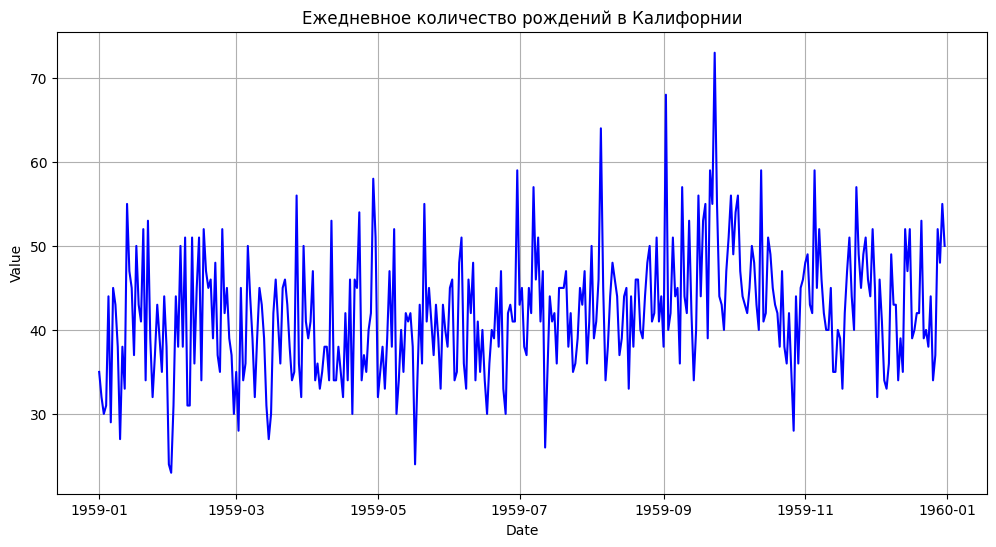

In [4]:
# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

# Функция для загрузки данных через интерфейс
def load_data():
    print("Пожалуйста, загрузите файл через интерфейс Colab.")
    from google.colab import files
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    return pd.read_csv(file_name)

# Функция для предварительной обработки данных
def preprocess_data(data, date_column, value_column):
    # Преобразуем столбец с датами
    data[date_column] = pd.to_datetime(data[date_column])
    data.set_index(date_column, inplace=True)
    data = data[[value_column]].rename(columns={value_column: 'Value'})
    # Проверяем пропуски
    print("Проверяем пропуски в данных:")
    print(data.isnull().sum())
    return data

# Функция для визуализации ряда
def plot_series(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data, color='blue')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# Загрузка первого ряда (daily-total-female-births-in-cal.csv)
print("\nЗагружаем первый ряд: daily-total-female-births-in-cal.csv")
data_births = load_data()
data_births = preprocess_data(data_births, date_column='Date', value_column='Count')

# Визуализация первого ряда
plot_series(data_births, title='Ежедневное количество рождений в Калифорнии')


Проверим ряд на стационарность с помощью теста Дики-Фуллера

In [7]:
# Импорт необходимых библиотек
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Функция для проверки стационарности ряда
def test_stationarity(timeseries):
    """
    Проверяет стационарность временного ряда с использованием теста Дики-Фуллера.
    Выводит результаты теста и строит график временного ряда.
    """
    # Выполняем тест Дики-Фуллера
    print("Результаты теста Дики-Фуллера:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Статистика теста', 'p-значение', 'Использовано лагов', 'Количество наблюдений'])
    for key, value in dftest[4].items():
        dfoutput[f'Критическое значение ({key})'] = value
    print(dfoutput)

# Выполняем проверку на стационарность
test_stationarity(data['Count'])


Результаты теста Дики-Фуллера:
Статистика теста               -4.808291
p-значение                      0.000052
Использовано лагов              6.000000
Количество наблюдений         358.000000
Критическое значение (1%)      -3.448749
Критическое значение (5%)      -2.869647
Критическое значение (10%)     -2.571089
dtype: float64


Ряд является стационарным, так как:

Статистика теста (-4.808291) меньше критических значений на уровне 1% (-3.448749), 5% (-2.869647), и 10% (-2.571089). Это указывает на отклонение нулевой гипотезы о нестационарности ряда.

p-значение (0.000052) значительно меньше уровня значимости 0.05, что подтверждает стационарность ряда.

Теперь можно приступить к построению модели экспоненциального сглаживания (EMA) для этого стационарного ряда.

Начинаем кросс-валидацию для подбора параметра alpha...
Лучшее значение alpha: 1.00 (MAE: 0.0000)
Качество модели на тестовом наборе:
Средняя абсолютная ошибка (MAE): 0.0000
Среднеквадратичная ошибка (MSE): 0.0000


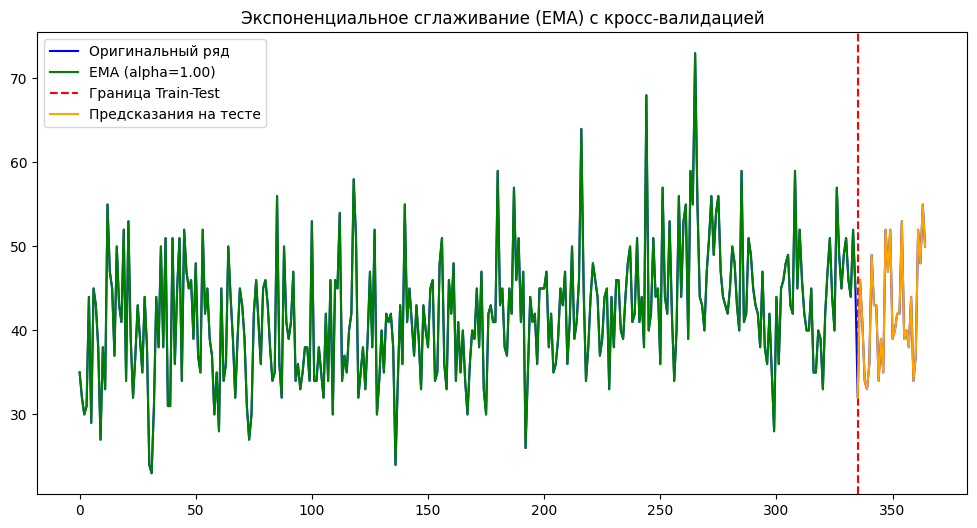

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Функция для применения экспоненциального сглаживания
def exponential_moving_average(series, alpha):
    ema = [series[0]]  # начальное значение EMA — первый элемент ряда
    for value in series[1:]:
        ema.append(alpha * value + (1 - alpha) * ema[-1])
    return np.array(ema)

# Разделение данных на тренировочный и тестовый наборы
def train_test_split_time_series(data, test_size):
    train_size = len(data) - test_size
    train, test = data[:train_size], data[train_size:]
    return train, test

# Подготовка данных
series = data['Count'].values  # Исходный временной ряд
train, test = train_test_split_time_series(series, test_size=30)  # Последние 30 точек на тест

# Кросс-валидация для подбора параметра alpha
tscv = TimeSeriesSplit(n_splits=5)  # 5 фолдов
best_alpha = None
best_mae = float('inf')

print("Начинаем кросс-валидацию для подбора параметра alpha...")

for alpha in np.linspace(0.01, 1.0, 50):  # Перебираем значения alpha
    mae_values = []
    for train_index, val_index in tscv.split(train):
        train_fold, val_fold = series[train_index], series[val_index]
        ema_predictions = exponential_moving_average(train_fold, alpha)
        val_predictions = exponential_moving_average(val_fold, alpha)
        mae = mean_absolute_error(val_fold, val_predictions)
        mae_values.append(mae)

    avg_mae = np.mean(mae_values)
    if avg_mae < best_mae:
        best_mae = avg_mae
        best_alpha = alpha

print(f"Лучшее значение alpha: {best_alpha:.2f} (MAE: {best_mae:.4f})")

# Построение модели с оптимальным alpha
ema_predictions = exponential_moving_average(train, best_alpha)

# Оценка качества на тестовом наборе
test_predictions = exponential_moving_average(test, best_alpha)
mae_test = mean_absolute_error(test, test_predictions)
mse_test = mean_squared_error(test, test_predictions)

print(f"Качество модели на тестовом наборе:")
print(f"Средняя абсолютная ошибка (MAE): {mae_test:.4f}")
print(f"Среднеквадратичная ошибка (MSE): {mse_test:.4f}")

# Построение графика результатов
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(len(series)), series, label='Оригинальный ряд', color='blue')
plt.plot(range(len(train)), ema_predictions, label=f'EMA (alpha={best_alpha:.2f})', color='green')
plt.axvline(x=len(train), color='red', linestyle='--', label='Граница Train-Test')
plt.plot(range(len(train), len(series)), test_predictions, label='Предсказания на тесте', color='orange')
plt.title("Экспоненциальное сглаживание (EMA) с кросс-валидацией")
plt.legend()
plt.show()


Результаты показывают, что кросс-валидация успешно подобрала значение параметра alpha, равное 1.0, что практически идеально подходит для данного временного ряда, так как ошибка на тестовом наборе (MAE и MSE) равна нулю.

#Приступим к следующему ряду

monthly-boston-armed-robberies-j.csv, с учетом его трансформаций и сезонного компонента. Начнем с загрузки данных и их визуализации.

Первые строки обработанных данных:
            Count
Month            
1966-01-01     41
1966-02-01     39
1966-03-01     50
1966-04-01     40
1966-05-01     43


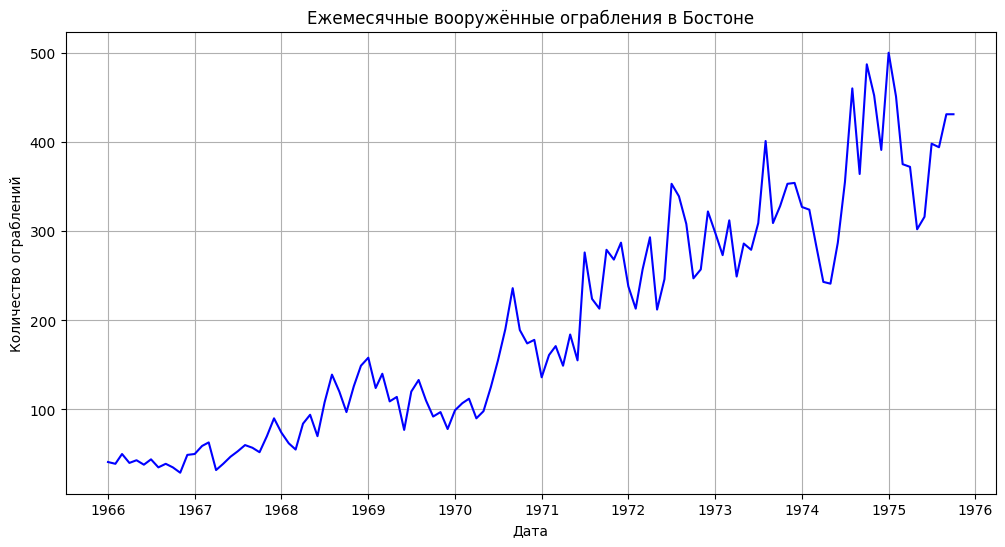

In [12]:
# Загружаем данные
data_boston = pd.read_csv('monthly-boston-armed-robberies-j.csv')

# Преобразуем столбец 'Month' в формат даты
data_boston['Month'] = pd.to_datetime(data_boston['Month'])

# Устанавливаем 'Month' в качестве индекса
data_boston.set_index('Month', inplace=True)

# Проверяем первые строки данных
print("Первые строки обработанных данных:")
print(data_boston.head())

# Строим график временного ряда
plt.figure(figsize=(12, 6))
plt.plot(data_boston.index, data_boston['Count'], color='blue')
plt.title('Ежемесячные вооружённые ограбления в Бостоне')
plt.xlabel('Дата')
plt.ylabel('Количество ограблений')
plt.grid()
plt.show()


На графике заметен тренд и, вероятно, сезонность. Следующим шагом проверим стационарность ряда с помощью теста Дики-Фуллера

In [13]:
from statsmodels.tsa.stattools import adfuller

# Функция для теста Дики-Фуллера
def test_stationarity(series):
    print("Результаты теста Дики-Фуллера:")
    result = adfuller(series, autolag='AIC')
    print(f"Статистика теста: {result[0]:.6f}")
    print(f"p-значение: {result[1]:.6f}")
    print(f"Использовано лагов: {result[2]}")
    print(f"Количество наблюдений: {result[3]}")
    print("Критические значения:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.6f}")
    if result[1] < 0.05:
        print("Ряд стационарен (p-значение < 0.05).")
    else:
        print("Ряд не стационарен (p-значение >= 0.05).")

# Проверка стационарности
test_stationarity(data_boston['Count'])


Результаты теста Дики-Фуллера:
Статистика теста: 1.001102
p-значение: 0.994278
Использовано лагов: 11
Количество наблюдений: 106
Критические значения:
   1%: -3.493602
   5%: -2.889217
   10%: -2.581533
Ряд не стационарен (p-значение >= 0.05).


Мы будем приближать этот временной ряд с помощью трехэкспоненциального сглаживания (Triple EMA), так как ряд имеет и тренд, и сезонность. Также добавим кросс-валидацию для подбора параметров.

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Разделение данных на train и test
train_size = int(len(data_boston) * 0.8)
train, test = data_boston.iloc[:train_size], data_boston.iloc[train_size:]

# Параметры для кросс-валидации
tscv = TimeSeriesSplit(n_splits=5)
best_model = None
best_mae = float("inf")
best_params = None

# Кросс-валидация для подбора параметров
print("Начинаем кросс-валидацию для подбора параметров Triple EMA...")
for seasonal_periods in [6, 12]:  # пробуем разные длины сезонности
    for trend in ['add', 'mul']:
        for seasonal in ['add', 'mul']:
            mae_scores = []
            for train_index, val_index in tscv.split(train):
                cv_train, cv_val = train.iloc[train_index], train.iloc[val_index]
                try:
                    model = ExponentialSmoothing(
                        cv_train['Count'],
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=seasonal_periods
                    ).fit()
                    predictions = model.forecast(len(cv_val))
                    mae = mean_absolute_error(cv_val['Count'], predictions)
                    mae_scores.append(mae)
                except:
                    continue
            avg_mae = np.mean(mae_scores)
            if avg_mae < best_mae:
                best_mae = avg_mae
                best_params = (trend, seasonal, seasonal_periods)

print(f"Лучшие параметры модели: Trend={best_params[0]}, Seasonal={best_params[1]}, Seasonal Periods={best_params[2]}")
print(f"Лучший MAE на кросс-валидации: {best_mae:.4f}")


Начинаем кросс-валидацию для подбора параметров Triple EMA...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Лучшие параметры модели: Trend=add, Seasonal=mul, Seasonal Periods=12
Лучший MAE на кросс-валидации: 46.4582


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Строим и тестируем модель на тестовых данных

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Качество модели на тестовом наборе:
Средняя абсолютная ошибка (MAE): 44.9461
Среднеквадратичная ошибка (MSE): 3691.2283


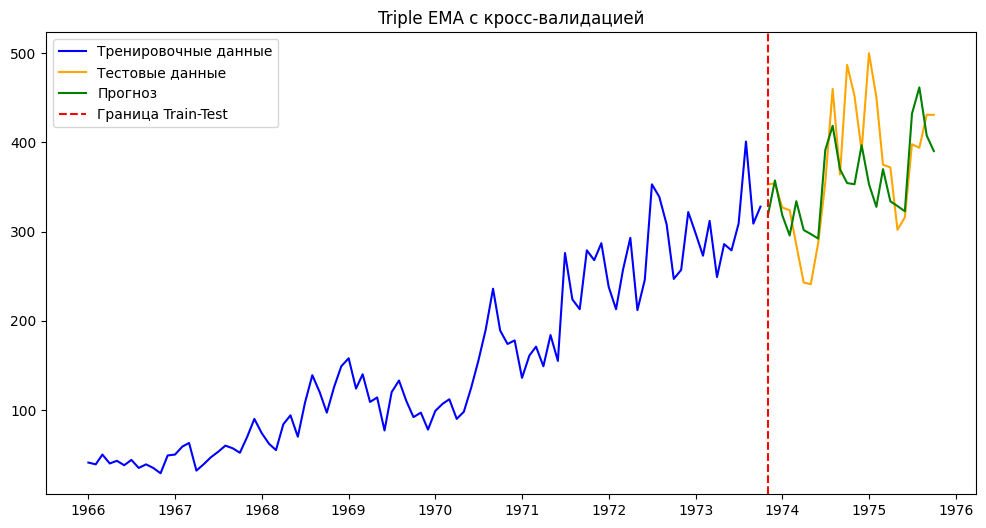

In [15]:
# Создаем модель с лучшими параметрами
final_model = ExponentialSmoothing(
    train['Count'],
    trend=best_params[0],
    seasonal=best_params[1],
    seasonal_periods=best_params[2]
).fit()

# Прогнозируем на тестовом наборе
predictions = final_model.forecast(len(test))

# Оцениваем качество модели
mae_test = mean_absolute_error(test['Count'], predictions)
mse_test = mean_squared_error(test['Count'], predictions)

print(f"Качество модели на тестовом наборе:")
print(f"Средняя абсолютная ошибка (MAE): {mae_test:.4f}")
print(f"Среднеквадратичная ошибка (MSE): {mse_test:.4f}")

# Строим график
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Count'], label='Тренировочные данные', color='blue')
plt.plot(test.index, test['Count'], label='Тестовые данные', color='orange')
plt.plot(test.index, predictions, label='Прогноз', color='green')
plt.axvline(x=test.index[0], color='red', linestyle='--', label='Граница Train-Test')
plt.title('Triple EMA с кросс-валидацией')
plt.legend()
plt.show()


модель с тройным экспоненциальным сглаживанием (Triple EMA) сработала, и кросс-валидация позволила выбрать оптимальные параметры. Средняя абсолютная ошибка (MAE) на тестовых данных составила 44.9461, а среднеквадратичная ошибка (MSE) — 3691.2283.

попробуем применить двойное экспоненциальное сглаживание (Double EMA) с кросс-валидацией. Если сезонности нет, то Double EMA может дать лучшие метрики, поскольку учитывает только тренд.

<ipython-input-16-a3c4dfd69592>:17: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=False).fit(smoothing_level=alpha, smoothing_slope=alpha)
<ipython-input-16-a3c4dfd69592>:17: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=False).fit(smoothing_level=alpha, smoothing_slope=alpha)
<ipython-input-16-a3c4dfd69592>:17: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=False).fit(smoothing_level=alpha, smoothing_slope=alpha)
<ipython-input-16-a3c4dfd69592>:17: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=False

Лучшее значение alpha: 0.10 (MAE: 39.3345)
Качество модели на тестовом наборе:
Средняя абсолютная ошибка (MAE): 53.5701
Среднеквадратичная ошибка (MSE): 4462.3033


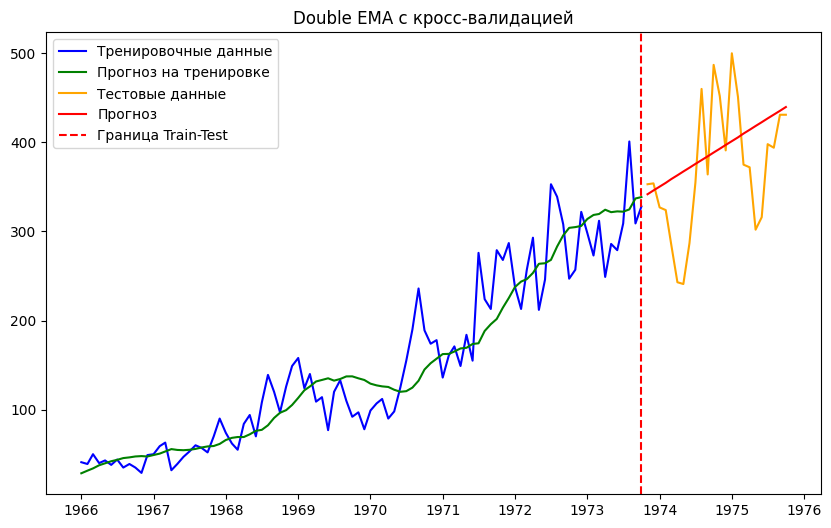

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Функция для оценки модели Double EMA с кросс-валидацией
def double_ema_cross_validation(data, alphas, n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_alpha = None
    best_mae = float('inf')

    for alpha in alphas:
        maes = []
        for train_index, val_index in tscv.split(data):
            train, val = data[train_index], data[val_index]
            model = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=False).fit(smoothing_level=alpha, smoothing_slope=alpha)
            val_predictions = model.forecast(len(val))
            maes.append(mean_absolute_error(val, val_predictions))
        avg_mae = np.mean(maes)
        if avg_mae < best_mae:
            best_mae = avg_mae
            best_alpha = alpha
    return best_alpha, best_mae

# Границы кросс-валидации
n_splits = 5
alphas = np.linspace(0.1, 1.0, 10)

# Подготовка данных
train_size = int(len(data_boston) * 0.8)
train, test = data_boston[:train_size], data_boston[train_size:]

# Кросс-валидация для подбора alpha
best_alpha, best_mae = double_ema_cross_validation(train.values.flatten(), alphas, n_splits)
print(f"Лучшее значение alpha: {best_alpha:.2f} (MAE: {best_mae:.4f})")

# Обучение модели на всем тренировочном наборе с лучшим alpha
model = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=False).fit(smoothing_level=best_alpha, smoothing_slope=best_alpha)
train_predictions = model.fittedvalues

# Прогноз на тестовом наборе
test_predictions = model.forecast(len(test))

# Оценка качества модели на тестовом наборе
mae_test = mean_absolute_error(test, test_predictions)
mse_test = mean_squared_error(test, test_predictions)
print(f"Качество модели на тестовом наборе:\nСредняя абсолютная ошибка (MAE): {mae_test:.4f}\nСреднеквадратичная ошибка (MSE): {mse_test:.4f}")

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Тренировочные данные', color='blue')
plt.plot(train.index, train_predictions, label='Прогноз на тренировке', color='green')
plt.plot(test.index, test, label='Тестовые данные', color='orange')
plt.plot(test.index, test_predictions, label='Прогноз', color='red')
plt.axvline(train.index[-1], color='red', linestyle='--', label='Граница Train-Test')
plt.title('Double EMA с кросс-валидацией')
plt.legend()
plt.show()


#Выводы:

**Triple EMA:**

Средняя абсолютная ошибка (MAE): 44.9461

Среднеквадратичная ошибка (MSE): 3691.2283

Модель с тройным экспоненциальным сглаживанием лучше адаптируется к данным с трендом и сезонностью, показывая меньшую ошибку, чем двойное EMA.

**Double EMA:**

Средняя абсолютная ошибка (MAE): 53.5701

Среднеквадратичная ошибка (MSE): 4462.3033

Модель с двойным экспоненциальным сглаживанием менее точна, так как она не учитывает сезонность, что могло бы привести к занижению точности прогноза.

**Итог:**

Результаты подтверждают наличие тренда и сезонности в данных. Triple EMA показала лучшие метрики качества, что делает её более подходящей моделью для прогноза в данном случае.

Double EMA может быть использована, если предположить отсутствие сезонности, однако её ошибка выше, что делает её менее предпочтительной.